# DATASCI W261: Machine Learning at Scale 

* **Sayantan Satpati**
* **sayantan.satpati@ischool.berkeley.edu**
* **W261**
* **Week-10**
* **Assignment-10**
* **Date of Submission: 17-NOV-2015**

#  === Week 10 ASSIGNMENTS ===

### Environment Setup - Initialize Spark

In [2]:
import os
import sys
#Escape L for line numbers
spark_home = os.environ['SPARK_HOME'] = '/Users/ssatpati/0-DATASCIENCE/TOOLS/spark-1.5.1-bin-hadoop2.6'
#spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


## HW10.0
---

### === HW 10.0: Short answer questions===

***What is Apache Spark and how is it different to Apache Hadoop?***

* Apache Spark™ is a fast and general engine for large-scale data processing.

* Spark is basically developed to overcome MapReduce's shortcoming that it is not optimized for of iterative algorithms and interactive data analysis which performs cyclic operations on same set of data. Spark uses Resilient Distributed Datasets (RDDs), immutable distributed collection of objects, which can be loaded into the memory for running iterative algorithms in a fast and efficient way.

#### Fill in the blanks:

* Spark API consists of interfaces to develop applications based on it in ***Java, Scala, and Python*** languages (list languages). 

* Using Spark, resource management can be done either in a single server instance or using a framework such as ***Mesos or Yarn*** in a distributed manner.

#### What is an RDD and show a fun example of creating one and bringing the first element back to the driver program.

* An RDD in Spark is simply an immutable distributed collection of objects. Each RDD is split into multiple partitions, which may be computed on different nodes of the cluster. RDDs can contain any type of Python, Java, or Scala objects, including user-defined classes.






In [2]:
print sc.parallelize([1,2,3,4,5,6,7,8,9]).take(1)

[1]


#### What is lazy evaluation and give an intuitoive example of lazy evaluation and comment on the massive computational savings to be had from lazy evaluation.


* Once created, RDDs offer two types of operations: transformations and actions. Transformations construct a new RDD from a previous one. For example, one common transformation is filtering data that matches a predicate. Actions, on the other hand, compute a result based on an RDD, and either return it to the driver program or save it to an external storage system (e.g., HDFS). 

* Transformations and actions are different because of the way Spark computes RDDs. Although you can define new RDDs any time, Spark computes them only in a lazy fashion—that is, the first time they are used in an action. This approach might seem unusual at first, but makes a lot of sense when you are working with Big Data.  For instance, consider Example below, where we defined a text file and then filtered the lines that include Python. If Spark were to load and store all the lines in the file as soon as we wrote lines = sc.textFile(...), it would waste a lot of storage space, given that we then immediately filter out many lines. Instead, once Spark sees the whole chain of transformations, it can compute just the data needed for its result. In fact, for the first() action, Spark scans the file only until it finds the first matching line; it doesn’t even read the whole file.

```
### Transformation ###

>>> pythonLines = lines.filter(lambda line: "Python" in line)

### Action ###

>>> pythonLines.first()
u'## Interactive Python Shell'
```

## HW10.1
___

In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document as a the example document to run an experiment.  Report the following: provide a sorted list of tokens in decreasing order of frequency of occurence.

In [5]:
lines = sc.textFile('MIDS-MLS-HW-10.txt')
print lines.count()

116


In [6]:
import re
# Showing the top 15 Words sorted based on Descending Word Count
lines.flatMap(lambda x: re.findall(r'[\w]+', x)) \
        .map(lambda x: (x, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .takeOrdered(20, key = lambda x: -x[1])

[(u'the', 44),
 (u'and', 23),
 (u'of', 17),
 (u'in', 17),
 (u'10', 15),
 (u'a', 12),
 (u'data', 11),
 (u'HW', 11),
 (u'code', 10),
 (u'to', 9),
 (u'clusters', 9),
 (u'KMeans', 8),
 (u'1', 7),
 (u'for', 7),
 (u'HW10', 7),
 (u'with', 7),
 (u'is', 7),
 (u'Using', 7),
 (u'on', 7),
 (u'2', 7)]

## HW 10.1.1
____

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.

In [7]:
import re
# Showing the top 15 Words sorted based on Descending Word Count
lines.flatMap(lambda x: re.findall(r'\b[a-z][a-zA-Z0-9]*\b', x)) \
        .map(lambda x: (x, 1)) \
        .reduceByKey(lambda x, y: x + y) \
        .takeOrdered(15, key = lambda x: -x[1])

[(u'the', 44),
 (u'and', 23),
 (u'of', 17),
 (u'in', 17),
 (u'a', 12),
 (u'data', 11),
 (u'code', 10),
 (u'to', 9),
 (u'clusters', 9),
 (u'for', 7),
 (u'with', 7),
 (u'is', 7),
 (u'on', 7),
 (u's', 6),
 (u'x', 6)]

## HW 10.2
___

```

===HW 10.2: KMeans a la MLLib ===
Using the following  MLlib-centric KMeans code snippet: 

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
# NOTE  kmeans_data.txt is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")


# NOTE  kmeans_data.txt is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

Run this code snippet and list the clusters that your find and compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.
```

In [11]:
!rm -rf myModelPath

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
# NOTE  kmeans_data.txt is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

print parsedData.collect()

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("\n### Within Set Sum of Squared Error = " + str(WSSSE))

print '\n### Cluster Centers: {0}'.format(clusters.clusterCenters)

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")


[array([ 0.,  0.,  0.]), array([ 0.1,  0.1,  0.1]), array([ 0.2,  0.2,  0.2]), array([ 9.,  9.,  9.]), array([ 9.1,  9.1,  9.1]), array([ 9.2,  9.2,  9.2])]

### Within Set Sum of Squared Error = 0.692820323028

### Cluster Centers: [array([ 0.1,  0.1,  0.1]), array([ 9.1,  9.1,  9.1])]


### Findings

* Within Set Sum of Squared Error = ***0.692820323028***

* Cluster Centers: ***[array([ 0.1,  0.1,  0.1]), array([ 9.1,  9.1,  9.1])]***

## HW 10.3
___

```
=== HW 10.3: ===
Download the following KMeans notebook:

https://www.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb?dl=0

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

  -- plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
  -- in each plot please report the Within Set Sum of Squared Errors for the found clusters. Comment on the progress of this measure as the KMEans algorithms runs for more iterations
```

### Generate Data

In [12]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

### Plot Data

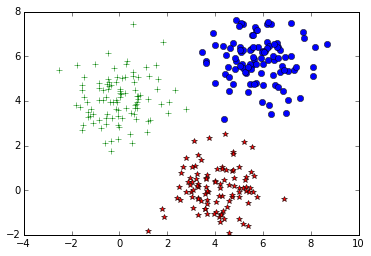

In [13]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o', color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+', color = 'green')
pylab.show()

### Run KMeans using Spark Mllib



[1] ### Number of Iterations: 1
[1] Within Set Sum of Squared Error = 751.211780901
[1] Cluster Centers: [array([ 3.40803497,  5.28965097]), array([ 3.98093152, -1.28733331]), array([ 2.97179035,  0.96202015])]


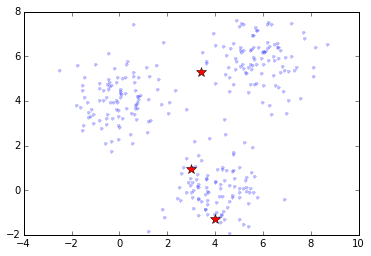



[10] ### Number of Iterations: 10
[10] Within Set Sum of Squared Error = 376.861109478
[10] Cluster Centers: [array([ 5.82428678,  5.83461633]), array([-0.0177415 ,  4.09952867]), array([ 4.02499157,  0.0788202 ])]


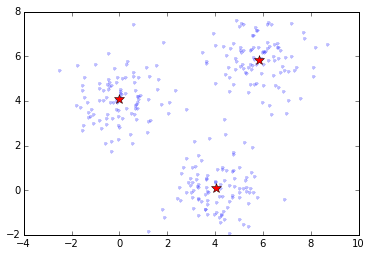



[20] ### Number of Iterations: 20
[20] Within Set Sum of Squared Error = 376.861109478
[20] Cluster Centers: [array([ 5.82428678,  5.83461633]), array([ 4.02499157,  0.0788202 ]), array([-0.0177415 ,  4.09952867])]


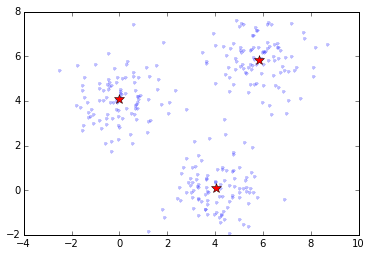



[100] ### Number of Iterations: 100
[100] Within Set Sum of Squared Error = 376.861109478
[100] Cluster Centers: [array([ 5.82428678,  5.83461633]), array([-0.0177415 ,  4.09952867]), array([ 4.02499157,  0.0788202 ])]


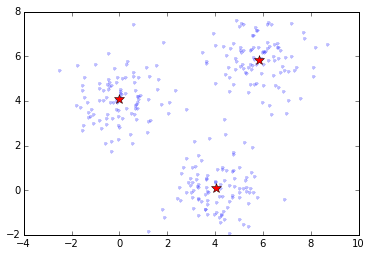

In [41]:
k = 3
iterations = [1,10,20,100]

def error(clusters, point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue', alpha=0.25)
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue', alpha=0.25)
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue', alpha=0.25)
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

# Create RDD
rddData = sc.parallelize(data)
rddData.cache()
#print rddData.count()

clusters = None

for i in iterations:
    print '\n\n[{0}] ### Number of Iterations: {0}'.format(i)
    # Build the model (cluster the data)
    clusters = KMeans.train(rddData, k, maxIterations=i,
        runs=1, initializationMode="random")
    
    WSSSE = rddData.map(lambda point: error(clusters, point)).reduce(lambda x, y: x + y)
    
    print("[{0}] Within Set Sum of Squared Error = {1}".format(i, WSSSE))
    print '[{0}] Cluster Centers: {1}'.format(i, clusters.clusterCenters)
    
    # Plot the points & centroids
    plot_iteration(clusters.clusterCenters)
    

**It is evident from the above plots that as the number of the iterations increases, the error (within cluster sum of squared error) continues to decrease and the centroids tend to move towards the middle of the points. There is not much difference between 20 & 100 iterations, indicating that covergence was reached for this dataset by 20 iterations.**

## HW10.4
___

```
==HW 10.4: ===
Using the KMeans code (homegrown code) provided repeat the experiments in HW10.3. Comment on any differences between the results in HW10.3 and HW10.4. Explain.
```

### Run KMeans using Homegrown Code with Spark

### Iteration: 1
[[-0.20343358  1.40418613]
 [ 3.98724182  2.61084674]
 [ 1.76500666  5.59927668]]


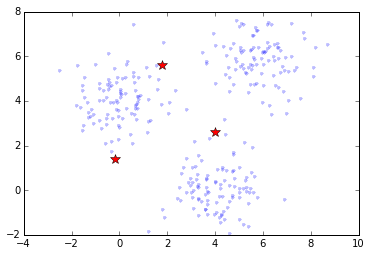

### Iteration: 10
[[-0.19735785  2.79115731]
 [ 4.94487658  2.31048157]
 [ 2.07127357  5.48337367]]


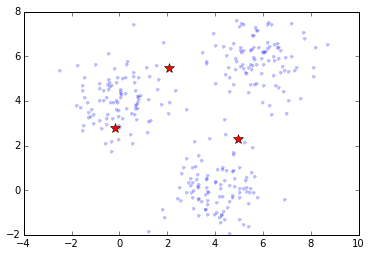

### Iteration: 20
[[-0.29234796  3.57639868]
 [ 4.91232112  1.93851062]
 [ 3.69903554  5.90642892]]


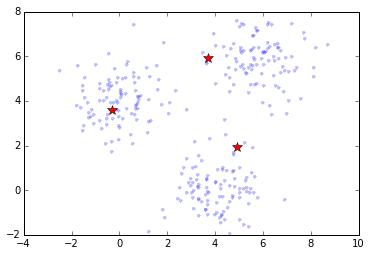

### Iteration: 100
[[-0.1321773   4.01277358]
 [ 4.22377503  0.3935243 ]
 [ 5.51739044  5.99176964]]


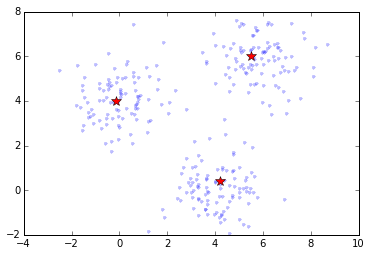

Final Results:
[[-0.1321773   4.01277358]
 [ 4.22377503  0.3935243 ]
 [ 5.51739044  5.99176964]]


In [44]:
K = 3
iterations = [1,10,20,100]

# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

#Calculate which class each data point belongs to
def nearest_centroid(x):
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

iter_num = 0
for i in range(100):  
    res = rddData.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    #if np.sum(np.absolute(centroids_new-centroids))<0.01:
    #    break
    if i+1 in iterations:
        print "### Iteration: " + str(i+1)
        iter_num = iter_num + 1 
        centroids = centroids_new
        print centroids
        plot_iteration(centroids)
print "Final Results:"
print centroids

### Analysis of Results from 10.3 & 10.4

#### Results from 10.3

```
[100] ### Number of Iterations: 100
[100] Within Set Sum of Squared Error = 376.861109478
[100] Cluster Centers: [array([ 5.82428678,  5.83461633]), array([-0.0177415 ,  4.09952867]), array([ 4.02499157,  0.0788202 ])]
```

#### Results from 10.4

```
Final Results:
[[-0.1321773   4.01277358]
 [ 4.22377503  0.3935243 ]
 [ 5.51739044  5.99176964]]
```

***It can be seen from above that the cluster centers are very similar for both Mllib and Homegrown algorithms***

## HW10.5 (Optional) [--- DIDN'T ATTEMPT ---]
---

```
==HW 10.5: === (OPTIONAL)
Using the KMeans code provided modify it to do a weighted KMeans and repeat the experiements in HW10.3. Comment on any differences between the results in HW10.3 and HW10.5. Explain.
```

## HW 10.6 (Optional)

```
==HW 10.6: Linear Regression ===  (OPTIONAL)
HW 10.6.1
Using the following linear regression notebook:

 https://www.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb?dl=0 

Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots and words. 

HW 10.6.2
In the notebook provide, in the cell labeled "Gradient descent (regularization)".

Fill in the blanks and get this code to work for LASS0 and RIDGE linear regression.

Using the data from 10.6.1 tune the hyper parameters of your LASS0 and RIDGE regression. Report your findings with words and plots.
```

## HW10.6.1
___

### Data Generation

In [34]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

### Data Viz

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

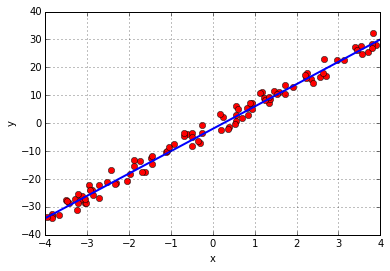

In [36]:
!rm train.csv
w = [8,-2]
data_generate('train.csv', w, 100)
dataPlot('train.csv',w)

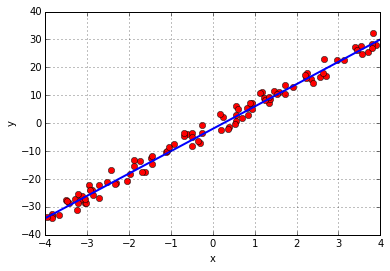

In [37]:
!rm test.csv
w = [8,-2]
data_generate('test.csv', w, 100)
dataPlot('test.csv',w)

[LabeledPoint(-1.20623543022, [0.390508031419]), LabeledPoint(13.5737724217, [1.72151493098]), LabeledPoint(5.50818094805, [0.822107008573])]
Test [[0.390508031418598], [1.7215149309793558], [0.822107008573151]]
Test_x [-1.2062354302179288, 13.573772421743222, 5.508180948046128]
Test_y [0.390508031418598, 1.7215149309793558, 0.822107008573151]

 After 1 iterations RSME: 509327.435167

 After 2 iterations RSME: 3974346.73949

 After 5 iterations RSME: 97231561.7842

 After 10 iterations RSME: 35556827.9027

 After 15 iterations RSME: 28122.7699857

 After 20 iterations RSME: 656.745748546

 After 25 iterations RSME: 656.701896049

 After 50 iterations RSME: 656.701896049

 After 100 iterations RSME: 656.701896049


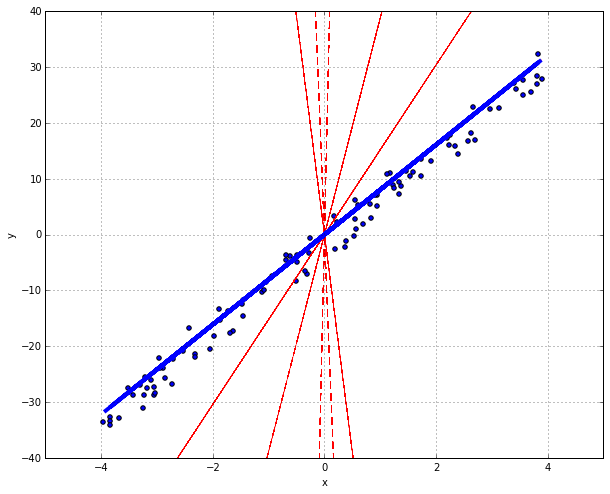

In [81]:
import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
iterations = [1,2,5,10,15,20,25,50,100]

def labeled_point(value):
    t = value.split(',')
    return LabeledPoint(float(t[0]), [float(t[1])])

#train = sc.textFile('train.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
train = sc.textFile('train.csv').map(labeled_point).cache()
print train.take(3)
test = sc.textFile('test.csv').map(lambda line: [float(line.split(',')[1])]).cache()
test_y = sc.textFile('test.csv').map(lambda line: float(line.split(',')[0])).collect()
test_x = test.flatMap(lambda x: x).collect()
print 'Test', test.take(3)
print 'Test_x', test_y[:3]
print 'Test_y', test_x[:3]

plt.figure(figsize=(10,8))
#plt.plot(test_x, test_y, 'o'+'r', label="True Line", linewidth=4.0)
#plt.plot(test_x, test_y, 'r--')
plt.scatter(test_x, test_y)
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.ylim([-4,4])
plt.ylim([-40,40])
    
for i in iterations:
    lrm = LinearRegressionWithSGD.train(train, iterations=i,
                               initialWeights=np.array([1.0]))
    y = lrm.predict(test).collect()
    
    rmse = np.sum( (np.array(test_y) - np.array(y))**2 )
    print '\n After {0} iterations RSME: {1}'.format(i, rmse)
    
    if i == iterations[-1]:
        plt.plot(test_x, y, 'b--', label="After {0} Iterations".format(i), linewidth=4.0)
    else:
        plt.plot(test_x, y, 'r--', label="After {0} Iterations".format(i), linewidth=0.5)
    
    

**From above plot & the RMSE reported, it can be seen that the regressor has converged on/before 25 iterations with a RMSE of 656.701896049***

## HW 10.6.2
___

In [99]:
def linearRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = np.abs(w)
        elif regType == "Lasso":
            wReg = np.square(w)
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

In [100]:
np.random.seed(400)
data = sc.textFile('train.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
print data.take(3)

print '\nOLS: ', linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="None")
print '\nRidge: ', linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Ridge")
print '\nLasso: ', linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Lasso")

[[-1.2062354302179288, 0.390508031418598, 1.0], [13.573772421743222, 1.7215149309793558, 1.0], [5.508180948046128, 0.822107008573151, 1.0]]

OLS:  [ 7.9847391 -1.6085985]

Ridge:  [ 7.98397877 -1.60910998]

Lasso:  [ 7.97890316 -1.60715984]
